In [38]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option("display.max_columns", None)
import xgboost as xgb
from sklearn import tree
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import GaussianNB
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, roc_auc_score, plot_confusion_matrix, fbeta_score
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
import warnings

In [2]:
df_crashes = pd.read_csv('data/Crashes.csv')
df_cars= pd.read_csv('data/Vehicles.csv')
df_ppl= pd.read_csv('data/People.csv')

C:\Users\sethk\anaconda3\envs\learn-env\lib\site-packages\IPython\core\interactiveshell.py:3145: DtypeWarning: Columns (33) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
C:\Users\sethk\anaconda3\envs\learn-env\lib\site-packages\IPython\core\interactiveshell.py:3145: DtypeWarning: Columns (19,21,40,41,42,44,48,49,50,53,55,58,59,61,71) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
C:\Users\sethk\anaconda3\envs\learn-env\lib\site-packages\IPython\core\interactiveshell.py:3145: DtypeWarning: Columns (12,13,20,21,22,23,24,25,26,27,29) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
df_crashes.columns = df_crashes.columns.str.strip().str.lower()
df_cars.columns = df_cars.columns.str.strip().str.lower()
df_ppl.columns = df_ppl.columns.str.strip().str.lower()

In [4]:
df_crashes['injury'] = df_crashes['injuries_total'] >=1
df_crashes['injury']= df_crashes['injury'].astype(int)

In [5]:
df_crashes[['street_direction', 'street_name']] = df_crashes[['street_direction', 'street_name']].astype(str)
df_crashes['street']= df_crashes['street_direction'] + ' ' + df_crashes['street_name']

In [6]:
ppl_in_ppl_df = df_ppl[(df_ppl.person_type == 'DRIVER')]

In [7]:
# converting crash_date to datetime for future dataset split
df_crashes['crash_date'] = pd.to_datetime(df_crashes['crash_date'])

In [8]:
m1 = pd.merge(df_cars, ppl_in_ppl_df, how='left', on=['crash_record_id'])
m1.head()

,crash_unit_id,crash_record_id,rd_no_x,crash_date_x,unit_no,unit_type,num_passengers,vehicle_id_x,cmrc_veh_i,make,model,lic_plate_state,vehicle_year,vehicle_defect,vehicle_type,vehicle_use,travel_direction,maneuver,towed_i,fire_i,occupant_cnt,exceed_speed_limit_i,towed_by,towed_to,area_00_i,area_01_i,area_02_i,area_03_i,area_04_i,area_05_i,area_06_i,area_07_i,area_08_i,area_09_i,area_10_i,area_11_i,area_12_i,area_99_i,first_contact_point,cmv_id,usdot_no,ccmc_no,ilcc_no,commercial_src,gvwr,carrier_name,carrier_state,carrier_city,hazmat_placards_i,hazmat_name,un_no,hazmat_present_i,hazmat_report_i,hazmat_report_no,mcs_report_i,mcs_report_no,hazmat_vio_cause_crash_i,mcs_vio_cause_crash_i,idot_permit_no,wide_load_i,trailer1_width,trailer2_width,trailer1_length,trailer2_length,total_vehicle_length,axle_cnt,vehicle_config,cargo_body_type,load_type,hazmat_out_of_service_i,mcs_out_of_service_i,hazmat_class,person_id,person_type,rd_no_y,vehicle_id_y,crash_date_y,seat_no,city,state,zipcode,sex,age,drivers_license_state,drivers_license_class,safety_equipment,airbag_deployed,ejection,injury_classification,hospital,ems_agency,ems_run_no,driver_action,driver_vision,physical_condition,pedpedal_action,pedpedal_visibility,pedpedal_location,bac_result,bac_result value,cell_phone_use
0,829999,24ddf9fd8542199d832e1c223cc474e5601b356f1d77a6...,JD124535,01/22/2020 06:25:00 AM,1,DRIVER,NaN,796949.0,NaN,INFINITI,UNKNOWN,IL,2017.0,NONE,PASSENGER,PERSONAL,N,STRAIGHT AHEAD,NaN,NaN,1.0,NaN,NaN,NaN,NaN,Y,Y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FRONT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,O829999,DRIVER,JD124535,796949.0,01/22/2020 06:25:00 AM,NaN,ACAMPO,CA,95220,M,35.0,CA,NaN,SAFETY BELT USED,DID NOT DEPLOY,NONE,NO INDICATION OF INJURY,NaN,NaN,NaN,NONE,NOT OBSCURED,NORMAL,NaN,NaN,NaN,TEST NOT OFFERED,NaN,NaN
1,749947,81dc0de2ed92aa62baccab641fa377be7feb1cc47e6554...,JC451435,09/28/2019 03:30:00 AM,1,DRIVER,NaN,834816.0,NaN,HONDA,CIVIC,IL,2016.0,UNKNOWN,PASSENGER,PERSONAL,N,STRAIGHT AHEAD,NaN,NaN,1.0,NaN,NaN,NaN,NaN,Y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FRONT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,O749947,DRIVER,JC451435,834816.0,09/28/2019 03:30:00 AM,NaN,CHICAGO,IL,60651,M,25.0,IL,D,NONE PRESENT,DEPLOYMENT UNKNOWN,NONE,NO INDICATION OF INJURY,NaN,NaN,NaN,UNKNOWN,UNKNOWN,UNKNOWN,NaN,NaN,NaN,TEST NOT OFFERED,NaN,NaN
2,749949,81dc0de2ed92aa62baccab641fa377be7feb1cc47e6554...,JC451435,09/28/2019 03:30:00 AM,2,PARKED,NaN,834819.0,NaN,TOYOTA,YARIS,IL,2010.0,NONE,UNKNOWN/NA,PERSONAL,N,PARKED,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Y,NaN,NaN,NaN,NaN,ROOF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,O749947,DRIVER,JC451435,834816.0,09/28/2019 03:30:00 AM,NaN,CHICAGO,IL,60651,M,25.0,IL,D,NONE PRESENT,DEPLOYMENT UNKNOWN,NONE,NO INDICATION OF INJURY,NaN,NaN,NaN,UNKNOWN,UNKNOWN,UNKNOWN,NaN,NaN,NaN,TEST NOT OFFERED,NaN,NaN
3,749950,81dc0de2ed92aa62baccab641fa377be7feb1cc47e6554...,JC451435,09/28/2019 03:30:00 AM,3,PARKED,NaN,834817.0,NaN,GENERAL MOTORS CORPORATION (GMC),SIERRA,IL,2008.0,UNKNOWN,UNKNOWN/NA,UNKNOWN/NA,N,PARKED,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Y,NaN,NaN,NaN,NaN,ROOF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,O749947,DRIVER,JC451435,834816.0,09/28/2019 03:30:00 AM,NaN,CHICAGO,IL,60651,M,25.0,IL,D,NONE PRESENT,DEPLOYMENT UNKNOWN,NONE,NO INDICATION OF INJURY,NaN,NaN,NaN,UNKNOWN,UNKNOWN,UNKNOWN,NaN,NaN,NaN,TEST NOT OFFERED,NaN,NaN
4,871921,af84fb5c8d996fcd3aefd36593c3a02e6e7509eeb27568...,JD208731,04/13/2020 10:50:00 PM,2,DRIVER,NaN,827212.0,NaN,BUICK,ENCORE,IL,NaN,NONE,PASSENGER,PERSONAL,W,STRAIGHT AHEAD,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,Na

In [9]:
m2 = pd.merge(m1, df_crashes, how='left', on=['crash_record_id'])
m2.head()

,crash_unit_id,crash_record_id,rd_no_x,crash_date_x,unit_no,unit_type,num_passengers,vehicle_id_x,cmrc_veh_i,make,model,lic_plate_state,vehicle_year,vehicle_defect,vehicle_type,vehicle_use,travel_direction,maneuver,towed_i,fire_i,occupant_cnt,exceed_speed_limit_i,towed_by,towed_to,area_00_i,area_01_i,area_02_i,area_03_i,area_04_i,area_05_i,area_06_i,area_07_i,area_08_i,area_09_i,area_10_i,area_11_i,area_12_i,area_99_i,first_contact_point,cmv_id,usdot_no,ccmc_no,ilcc_no,commercial_src,gvwr,carrier_name,carrier_state,carrier_city,hazmat_placards_i,hazmat_name,un_no,hazmat_present_i,hazmat_report_i,hazmat_report_no,mcs_report_i,mcs_report_no,hazmat_vio_cause_crash_i,mcs_vio_cause_crash_i,idot_permit_no,wide_load_i,trailer1_width,trailer2_width,trailer1_length,trailer2_length,total_vehicle_length,axle_cnt,vehicle_config,cargo_body_type,load_type,hazmat_out_of_service_i,mcs_out_of_service_i,hazmat_class,person_id,person_type,rd_no_y,vehicle_id_y,crash_date_y,seat_no,city,state,zipcode,sex,age,drivers_license_state,drivers_license_class,safety_equipment,airbag_deployed,ejection,injury_classification,hospital,ems_agency,ems_run_no,driver_action,driver_vision,physical_condition,pedpedal_action,pedpedal_visibility,pedpedal_location,bac_result,bac_result value,cell_phone_use,rd_no,crash_date_est_i,crash_date,posted_speed_limit,traffic_control_device,device_condition,weather_condition,lighting_condition,first_crash_type,trafficway_type,lane_cnt,alignment,roadway_surface_cond,road_defect,report_type,crash_type,intersection_related_i,not_right_of_way_i,hit_and_run_i,damage,date_police_notified,prim_contributory_cause,sec_contributory_cause,street_no,street_direction,street_name,beat_of_occurrence,photos_taken_i,statements_taken_i,dooring_i,work_zone_i,work_zone_type,workers_present_i,num_units,most_severe_injury,injuries_total,injuries_fatal,injuries_incapacitating,injuries_non_incapacitating,injuries_reported_not_evident,injuries_no_indication,injuries_unknown,crash_hour,crash_day_of_week,crash_month,latitude,longitude,location,injury,street
0,829999,24ddf9fd8542199d832e1c223cc474e5601b356f1d77a6...,JD124535,01/22/2020 06:25:00 AM,1,DRIVER,NaN,796949.0,NaN,INFINITI,UNKNOWN,IL,2017.0,NONE,PASSENGER,PERSONAL,N,STRAIGHT AHEAD,NaN,NaN,1.0,NaN,NaN,NaN,NaN,Y,Y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FRONT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,O829999,DRIVER,JD124535,796949.0,01/22/2020 06:25:00 AM,NaN,ACAMPO,CA,95220,M,35.0,CA,NaN,SAFETY BELT USED,DID NOT DEPLOY,NONE,NO INDICATION OF INJURY,NaN,NaN,NaN,NONE,NOT OBSCURED,NORMAL,NaN,NaN,NaN,TEST NOT OFFERED,NaN,NaN,JD124535,NaN,2020-01-22 06:25:00,30,NO CONTROLS,NO CONTROLS,CLEAR,DAWN,OTHER NONCOLLISION,DIVIDED - W/MEDIAN (NOT RAISED),NaN,STRAIGHT AND LEVEL,DRY,NO DEFECTS,NOT ON SCENE (DESK REPORT),NO INJURY / DRIVE AWAY,NaN,NaN,NaN,"$501 - $1,500",01/22/2020 12:30:00 PM,UNABLE TO DETERMINE,UNABLE TO DETERMINE,1525,S,CALIFORNIA BLVD,1023.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NO INDICATION OF INJURY,0.0,0.0,0.0,0.0,0.0,1.0,0.0,6,4,1,41.860250,-87.695575,POINT (-87.695575177986 41.860250253825),0,S CALIFORNIA BLVD
1,749947,81dc0de2ed92aa62baccab641fa377be7feb1cc47e6554...,JC451435,09/28/2019 03:30:00 AM,1,DRIVER,NaN,834816.0,NaN,HONDA,CIVIC,IL,2016.0,UNKNOWN,PASSENGER,PERSONAL,N,STRAIGHT AHEAD,NaN,NaN,1.0,NaN,NaN,NaN,NaN,Y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FRONT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,O749947,DRIVER,JC451435,834816.0,09/28/2019 03:30:00 AM,NaN,CHICAGO,IL,60651,M,25.0,IL,D,NONE PRESENT,DEPLOYMENT UNKNOWN,NONE,NO INDICATION OF INJURY,NaN,NaN,NaN,UNKNOWN,UNKNOWN,UNKNOWN,NaN,NaN,NaN,TEST NOT OFFERED,NaN,NaN,JC451435,Y,2019-09-28 03:30:00,30,NO CONTROLS,NO CONTROLS,RAIN,DARKNESS,PARKED MOTOR VEHICLE,NOT DIVIDED,NaN,STRAIGHT AND LEVEL,WET,NO DEFECTS,NaN,NO INJURY / DRIVE AWAY,NaN,NaN,Y,"OVER $1,

In [10]:
df = m2.drop_duplicates(subset=['crash_record_id'], keep='first')
df.head()

,crash_unit_id,crash_record_id,rd_no_x,crash_date_x,unit_no,unit_type,num_passengers,vehicle_id_x,cmrc_veh_i,make,model,lic_plate_state,vehicle_year,vehicle_defect,vehicle_type,vehicle_use,travel_direction,maneuver,towed_i,fire_i,occupant_cnt,exceed_speed_limit_i,towed_by,towed_to,area_00_i,area_01_i,area_02_i,area_03_i,area_04_i,area_05_i,area_06_i,area_07_i,area_08_i,area_09_i,area_10_i,area_11_i,area_12_i,area_99_i,first_contact_point,cmv_id,usdot_no,ccmc_no,ilcc_no,commercial_src,gvwr,carrier_name,carrier_state,carrier_city,hazmat_placards_i,hazmat_name,un_no,hazmat_present_i,hazmat_report_i,hazmat_report_no,mcs_report_i,mcs_report_no,hazmat_vio_cause_crash_i,mcs_vio_cause_crash_i,idot_permit_no,wide_load_i,trailer1_width,trailer2_width,trailer1_length,trailer2_length,total_vehicle_length,axle_cnt,vehicle_config,cargo_body_type,load_type,hazmat_out_of_service_i,mcs_out_of_service_i,hazmat_class,person_id,person_type,rd_no_y,vehicle_id_y,crash_date_y,seat_no,city,state,zipcode,sex,age,drivers_license_state,drivers_license_class,safety_equipment,airbag_deployed,ejection,injury_classification,hospital,ems_agency,ems_run_no,driver_action,driver_vision,physical_condition,pedpedal_action,pedpedal_visibility,pedpedal_location,bac_result,bac_result value,cell_phone_use,rd_no,crash_date_est_i,crash_date,posted_speed_limit,traffic_control_device,device_condition,weather_condition,lighting_condition,first_crash_type,trafficway_type,lane_cnt,alignment,roadway_surface_cond,road_defect,report_type,crash_type,intersection_related_i,not_right_of_way_i,hit_and_run_i,damage,date_police_notified,prim_contributory_cause,sec_contributory_cause,street_no,street_direction,street_name,beat_of_occurrence,photos_taken_i,statements_taken_i,dooring_i,work_zone_i,work_zone_type,workers_present_i,num_units,most_severe_injury,injuries_total,injuries_fatal,injuries_incapacitating,injuries_non_incapacitating,injuries_reported_not_evident,injuries_no_indication,injuries_unknown,crash_hour,crash_day_of_week,crash_month,latitude,longitude,location,injury,street
0,829999,24ddf9fd8542199d832e1c223cc474e5601b356f1d77a6...,JD124535,01/22/2020 06:25:00 AM,1,DRIVER,NaN,796949.0,NaN,INFINITI,UNKNOWN,IL,2017.0,NONE,PASSENGER,PERSONAL,N,STRAIGHT AHEAD,NaN,NaN,1.0,NaN,NaN,NaN,NaN,Y,Y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FRONT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,O829999,DRIVER,JD124535,796949.0,01/22/2020 06:25:00 AM,NaN,ACAMPO,CA,95220,M,35.0,CA,NaN,SAFETY BELT USED,DID NOT DEPLOY,NONE,NO INDICATION OF INJURY,NaN,NaN,NaN,NONE,NOT OBSCURED,NORMAL,NaN,NaN,NaN,TEST NOT OFFERED,NaN,NaN,JD124535,NaN,2020-01-22 06:25:00,30,NO CONTROLS,NO CONTROLS,CLEAR,DAWN,OTHER NONCOLLISION,DIVIDED - W/MEDIAN (NOT RAISED),NaN,STRAIGHT AND LEVEL,DRY,NO DEFECTS,NOT ON SCENE (DESK REPORT),NO INJURY / DRIVE AWAY,NaN,NaN,NaN,"$501 - $1,500",01/22/2020 12:30:00 PM,UNABLE TO DETERMINE,UNABLE TO DETERMINE,1525,S,CALIFORNIA BLVD,1023.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NO INDICATION OF INJURY,0.0,0.0,0.0,0.0,0.0,1.0,0.0,6,4,1,41.860250,-87.695575,POINT (-87.695575177986 41.860250253825),0,S CALIFORNIA BLVD
1,749947,81dc0de2ed92aa62baccab641fa377be7feb1cc47e6554...,JC451435,09/28/2019 03:30:00 AM,1,DRIVER,NaN,834816.0,NaN,HONDA,CIVIC,IL,2016.0,UNKNOWN,PASSENGER,PERSONAL,N,STRAIGHT AHEAD,NaN,NaN,1.0,NaN,NaN,NaN,NaN,Y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FRONT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,O749947,DRIVER,JC451435,834816.0,09/28/2019 03:30:00 AM,NaN,CHICAGO,IL,60651,M,25.0,IL,D,NONE PRESENT,DEPLOYMENT UNKNOWN,NONE,NO INDICATION OF INJURY,NaN,NaN,NaN,UNKNOWN,UNKNOWN,UNKNOWN,NaN,NaN,NaN,TEST NOT OFFERED,NaN,NaN,JC451435,Y,2019-09-28 03:30:00,30,NO CONTROLS,NO CONTROLS,RAIN,DARKNESS,PARKED MOTOR VEHICLE,NOT DIVIDED,NaN,STRAIGHT AND LEVEL,WET,NO DEFECTS,NaN,NO INJURY / DRIVE AWAY,NaN,NaN,Y,"OVER $1,

In [11]:
df = df[(df['weather_condition'] != 'UNKNOWN') & (df['weather_condition'] != 'OTHER')]

In [12]:
def rush_hour(time):
    if ((time >= 7 and time <= 9) or (time >= 15 and time <= 18)):
        return 1
    else:
        return 0
def rush_hour_day(day):
    if (day >= 2 and day <= 6):
        return 1
    else:
        return 0

df['rush_hour'] = (df['crash_hour'].apply(rush_hour) & df['crash_day_of_week'].apply(rush_hour_day))
df['rush_hour'].value_counts()
df

,crash_unit_id,crash_record_id,rd_no_x,crash_date_x,unit_no,unit_type,num_passengers,vehicle_id_x,cmrc_veh_i,make,model,lic_plate_state,vehicle_year,vehicle_defect,vehicle_type,vehicle_use,travel_direction,maneuver,towed_i,fire_i,occupant_cnt,exceed_speed_limit_i,towed_by,towed_to,area_00_i,area_01_i,area_02_i,area_03_i,area_04_i,area_05_i,area_06_i,area_07_i,area_08_i,area_09_i,area_10_i,area_11_i,area_12_i,area_99_i,first_contact_point,cmv_id,usdot_no,ccmc_no,ilcc_no,commercial_src,gvwr,carrier_name,carrier_state,carrier_city,hazmat_placards_i,hazmat_name,un_no,hazmat_present_i,hazmat_report_i,hazmat_report_no,mcs_report_i,mcs_report_no,hazmat_vio_cause_crash_i,mcs_vio_cause_crash_i,idot_permit_no,wide_load_i,trailer1_width,trailer2_width,trailer1_length,trailer2_length,total_vehicle_length,axle_cnt,vehicle_config,cargo_body_type,load_type,hazmat_out_of_service_i,mcs_out_of_service_i,hazmat_class,person_id,person_type,rd_no_y,vehicle_id_y,crash_date_y,seat_no,city,state,zipcode,sex,age,drivers_license_state,drivers_license_class,safety_equipment,airbag_deployed,ejection,injury_classification,hospital,ems_agency,ems_run_no,driver_action,driver_vision,physical_condition,pedpedal_action,pedpedal_visibility,pedpedal_location,bac_result,bac_result value,cell_phone_use,rd_no,crash_date_est_i,crash_date,posted_speed_limit,traffic_control_device,device_condition,weather_condition,lighting_condition,first_crash_type,trafficway_type,lane_cnt,alignment,roadway_surface_cond,road_defect,report_type,crash_type,intersection_related_i,not_right_of_way_i,hit_and_run_i,damage,date_police_notified,prim_contributory_cause,sec_contributory_cause,street_no,street_direction,street_name,beat_of_occurrence,photos_taken_i,statements_taken_i,dooring_i,work_zone_i,work_zone_type,workers_present_i,num_units,most_severe_injury,injuries_total,injuries_fatal,injuries_incapacitating,injuries_non_incapacitating,injuries_reported_not_evident,injuries_no_indication,injuries_unknown,crash_hour,crash_day_of_week,crash_month,latitude,longitude,location,injury,street,rush_hour
0,829999,24ddf9fd8542199d832e1c223cc474e5601b356f1d77a6...,JD124535,01/22/2020 06:25:00 AM,1,DRIVER,NaN,796949.0,NaN,INFINITI,UNKNOWN,IL,2017.0,NONE,PASSENGER,PERSONAL,N,STRAIGHT AHEAD,NaN,NaN,1.0,NaN,NaN,NaN,NaN,Y,Y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FRONT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,O829999,DRIVER,JD124535,796949.0,01/22/2020 06:25:00 AM,NaN,ACAMPO,CA,95220,M,35.0,CA,NaN,SAFETY BELT USED,DID NOT DEPLOY,NONE,NO INDICATION OF INJURY,NaN,NaN,NaN,NONE,NOT OBSCURED,NORMAL,NaN,NaN,NaN,TEST NOT OFFERED,NaN,NaN,JD124535,NaN,2020-01-22 06:25:00,30,NO CONTROLS,NO CONTROLS,CLEAR,DAWN,OTHER NONCOLLISION,DIVIDED - W/MEDIAN (NOT RAISED),NaN,STRAIGHT AND LEVEL,DRY,NO DEFECTS,NOT ON SCENE (DESK REPORT),NO INJURY / DRIVE AWAY,NaN,NaN,NaN,"$501 - $1,500",01/22/2020 12:30:00 PM,UNABLE TO DETERMINE,UNABLE TO DETERMINE,1525,S,CALIFORNIA BLVD,1023.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NO INDICATION OF INJURY,0.0,0.0,0.0,0.0,0.0,1.0,0.0,6,4,1,41.860250,-87.695575,POINT (-87.695575177986 41.860250253825),0,S CALIFORNIA BLVD,0
1,749947,81dc0de2ed92aa62baccab641fa377be7feb1cc47e6554...,JC451435,09/28/2019 03:30:00 AM,1,DRIVER,NaN,834816.0,NaN,HONDA,CIVIC,IL,2016.0,UNKNOWN,PASSENGER,PERSONAL,N,STRAIGHT AHEAD,NaN,NaN,1.0,NaN,NaN,NaN,NaN,Y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FRONT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,O749947,DRIVER,JC451435,834816.0,09/28/2019 03:30:00 AM,NaN,CHICAGO,IL,60651,M,25.0,IL,D,NONE PRESENT,DEPLOYMENT UNKNOWN,NONE,NO INDICATION OF INJURY,NaN,NaN,NaN,UNKNOWN,UNKNOWN,UNKNOWN,NaN,NaN,NaN,TEST NOT OFFERED,NaN,NaN,JC451435,Y,2019-09-28 03:30:00,30,NO CONTROLS,NO CONTROLS,RAIN,DARKNESS,PARKED MOTOR VEHICLE,NOT DIVIDED,NaN,STRAIGHT AND LEVEL,WET,NO DEFECTS,NaN,NO INJURY / DRIVE AWAY,NaN,NaN

In [13]:
def road_defect(status):
    if status == 'NO DEFECTS':
        return 0
    else:
        return 1
df['road_defect'] = df['road_defect'].apply(road_defect)
df['road_defect'].value_counts()

0    440085
1     75532
Name: road_defect, dtype: int64

In [14]:
df = df.drop('crash_day_of_week', axis=1)

In [15]:
df = df[df.road_defect != 'UNKNOWN']

In [16]:
columns = ['crash_date', 'crash_record_id', 'crash_date_x', 'latitude', 'longitude', 'injury', 'crash_month', 'crash_hour', 
           'street_name', 'damage', 'hit_and_run_i', 'roadway_surface_cond', 'road_defect',
          'weather_condition', 'driver_action', 'exceed_speed_limit_i',
          'prim_contributory_cause', 'first_crash_type', 'rush_hour'] 

In [17]:
df = df[columns]

In [18]:
cause_dict = {'FAILING TO YIELD RIGHT-OF-WAY': 'Breaking Rules of Road',
              'IMPROPER LANE USAGE': 'Reckless/Poor Driving',
             'DISREGARDING TRAFFIC SIGNALS' : 'Breaking Rules of Road',
             'IMPROPER TURNING/NO SIGNAL': 'Reckless/Poor Driving',
              'DISREGARDING STOP SIGN' : 'Breaking Rules of Road',
             'DISREGARDING OTHER TRAFFIC SIGNS': 'Breaking Rules of Road',
             'DISREGARDING ROAD MARKINGS': 'Breaking Rules of Road',
             'DISREGARDING YIELD SIGN': 'Breaking Rules of Road',
             'PASSING STOPPED SCHOOL BUS': 'Breaking Rules of Road',
             'TURNING RIGHT ON RED': 'Breaking Rules of Road',
              'FAILING TO REDUCE SPEED TO AVOID CRASH': 'Speed Related',
              'EXCEEDING AUTHORIZED SPEED LIMIT': 'Speed Related',
              'EXCEEDING SAFE SPEED FOR CONDITIONS': 'Speed Related',
              'FOLLOWING TOO CLOSELY': 'Reckless/Poor Driving',
              'IMPROPER OVERTAKING/PASSING': 'Reckless/Poor Driving',
              'IMPROPER BACKING': 'Reckless/Poor Driving',
              'DRIVING SKILLS/KNOWLEDGE/EXPERIENCE': 'Reckless/Poor Driving',
              'OPERATING VEHICLE IN ERRATIC, RECKLESS, CARELESS, NEGLIGENT OR AGGRESSIVE MANNER': 'Reckless/Poor Driving',
              'DRIVING ON WRONG SIDE/WRONG WAY': 'Reckless/Poor Driving',
              'UNDER THE INFLUENCE OF ALCOHOL/DRUGS (USE WHEN ARREST IS EFFECTED)': 'Drug/Alcohol Related',
              'HAD BEEN DRINKING (USE WHEN ARREST IS NOT MADE)': 'Drug/Alcohol Related',
              'PHYSICAL CONDITION OF DRIVER': 'Reckless/Poor Driving',
              'DISTRACTION - FROM INSIDE VEHICLE':'Distracted Driving',
              'CELL PHONE USE OTHER THAN TEXTING':'Distracted Driving',
              'TEXTING':'Distracted Driving',
              'DISTRACTION - OTHER ELECTRONIC DEVICE (NAVIGATION DEVICE, DVD PLAYER, ETC.)':'Distracted Driving',
              'WEATHER':"Outside World/Out of Driver's Control",
              'EQUIPMENT - VEHICLE CONDITION':"Outside World/Out of Driver's Control",
              'VISION OBSCURED (SIGNS, TREE LIMBS, BUILDINGS, ETC.)':"Outside World/Out of Driver's Control",
              'DISTRACTION - FROM OUTSIDE VEHICLE':"Outside World/Out of Driver's Control",
              'ROAD ENGINEERING/SURFACE/MARKING DEFECTS':"Outside World/Out of Driver's Control",
              'ROAD CONSTRUCTION/MAINTENANCE':"Outside World/Out of Driver's Control",
              'ANIMAL':"Outside World/Out of Driver's Control",
              'EQUIPMENT - VEHICLE CONDITION': "Outside World/Out of Driver's Control",
              'EVASIVE ACTION DUE TO ANIMAL, OBJECT, NONMOTORIST':"Outside World/Out of Driver's Control",
              'MOTORCYCLE ADVANCING LEGALLY ON RED LIGHT':"Outside World/Out of Driver's Control",
              'BICYCLE ADVANCING LEGALLY ON RED LIGHT':"Outside World/Out of Driver's Control",
              'UNABLE TO DETERMINE': 'Other/Unknown',
              'NOT APPLICABLE': 'Other/Unknown',
              'OBSTRUCTED CROSSWALKS': 'Other/Unknown',
              'BICYCLE ADVANCING LEGALLY ON RED LIGHT': 'Other/Unknown',
              'RELATED TO BUS STOP': 'Other/Unknown',
             'MOTORCYCLE ADVANCING LEGALLY ON RED LIGHT': 'Other/Unknown'}

In [19]:
df['Simple_Reason'] = df['prim_contributory_cause'].map(cause_dict)

In [20]:
weather_dict = {'CLEAR': 'neutral',
                'RAIN': 'bad',
                'SNOW': 'bad',
                'CLOUDY/OVERCAST': 'neutral',
                'FOG/SMOKE/HAZE': 'vision_obstruction',
                'SLEET/HAIL': 'extreme',
                'FREEZING RAIN/DRIZZLE': 'extreme',
                'BLOWING SNOW': 'vision_obstruction',
                'SEVERE CROSS WIND GATE': 'extreme',
                'BLOWING SAND, SOIL, DIRT': 'vision_obstruction'
}
df['weather_condition'] = df['weather_condition'].map(weather_dict)

In [21]:
df = pd.get_dummies(df,columns=['Simple_Reason', 'first_crash_type', 'weather_condition'])

In [22]:
df = df.drop(labels = ['crash_record_id','crash_date_x','latitude','longitude', 'street_name',
                       'damage','exceed_speed_limit_i', 'prim_contributory_cause', 'hit_and_run_i', 'crash_hour',
                        'crash_month', 'roadway_surface_cond', 'driver_action','Simple_Reason_Other/Unknown', 
                       'first_crash_type_OTHER NONCOLLISION'], axis=1)

In [23]:
df = (df[df['crash_date'] >= '2019-01-01 00:00:00'])

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 270740 entries, 0 to 1960927
Data columns (total 31 columns):
 #   Column                                               Non-Null Count   Dtype         
---  ------                                               --------------   -----         
 0   crash_date                                           270740 non-null  datetime64[ns]
 1   injury                                               270740 non-null  int32         
 2   road_defect                                          270740 non-null  int64         
 3   rush_hour                                            270740 non-null  int64         
 4   Simple_Reason_Breaking Rules of Road                 270740 non-null  uint8         
 5   Simple_Reason_Distracted Driving                     270740 non-null  uint8         
 6   Simple_Reason_Drug/Alcohol Related                   270740 non-null  uint8         
 7   Simple_Reason_Outside World/Out of Driver's Control  270740 non-null  uin

In [26]:
X = df.drop(['injury', 'crash_date'], axis=1)
y = df['injury']

## Train-Test-Split ##

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

## Models ##

In [28]:
dummy_clf = DummyClassifier()
dummy_clf.fit(X_train, y_train)

y_pred = dummy_clf.predict(X_test)

baseline_cv = cross_val_score(dummy_clf, X_train, y_train, scoring="neg_root_mean_squared_error")


print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))     
print("Recall:", recall_score(y_test, y_pred))
print("F1:", f1_score(y_test, y_pred))
print("FBeta", fbeta_score(y_test, y_pred, beta=0.5))
print("AUC", roc_auc_score(y_test, y_pred))
print("CVS", -(baseline_cv.mean()))

Accuracy: 0.7421142055108222
Precision: 0.14824048326781092
Recall: 0.15279699545364697
F1: 0.15048425560909134
FBeta 0.14912991472778486
AUC 0.4992449201563404
CVS 0.5066235476447603


C:\Users\sethk\anaconda3\envs\learn-env\lib\site-packages\sklearn\dummy.py:131: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  warnings.warn("The default value of strategy will change from "
C:\Users\sethk\anaconda3\envs\learn-env\lib\site-packages\sklearn\dummy.py:131: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  warnings.warn("The default value of strategy will change from "
C:\Users\sethk\anaconda3\envs\learn-env\lib\site-packages\sklearn\dummy.py:131: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  warnings.warn("The default value of strategy will change from "
C:\Users\sethk\anaconda3\envs\learn-env\lib\site-packages\sklearn\dummy.py:131: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  warnings.warn("The default value of strategy will change from "
C:\Users\sethk\anaconda3\envs\learn-env\lib\site-pac

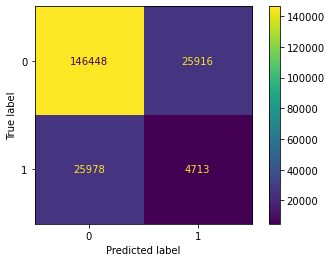

In [29]:
plot_confusion_matrix(dummy_clf, X_train, y_train)

In [39]:
pipeline_lr = Pipeline([('scalar1',StandardScaler()),
                       ('pca1',PCA(n_components=2)),
                       ('lr_classifier', LogisticRegression(random_state=42))])

pipeline_dt = Pipeline([('scalar2', StandardScaler()),
                        ('pca2',PCA(n_components=2)),
                        ('dt_classifier', DecisionTreeClassifier())])

pipeline_rf = Pipeline([('scalar3', StandardScaler()),
                       ('pca3', PCA(n_components=2)),
                       ('rf_classifier', RandomForestClassifier())])

pipeline_knn = Pipeline([('scalar4', StandardScaler()),
                        ('pca4', PCA(n_components=2)),
                        ('knn_classifier', KNeighborsClassifier())])

pipeline_gnb = Pipeline([('scalar5', StandardScaler()),
                        ('pca5', PCA(n_components=2)),
                        ('gnb_classifier', GaussianNB())])

pipeline_xgb = Pipeline([('scalar6', StandardScaler()),
                        ('pca6', PCA(n_components=20)),
                        ('xgb_classifier', GradientBoostingClassifier())])

In [40]:
pipelines = [pipeline_lr, pipeline_dt, pipeline_rf, pipeline_knn, pipeline_gnb, pipeline_xgb]

In [41]:
best_accuracy = 0.0
best_classifier = 0
best_pipeline = ""

In [42]:
pipe_dict = {0: 'Logistic Regression', 1: 'Decision Tree', 2: 'RandomForest', 3: 'KNearestNeighbors', 4: 'Gaussian Naive Bayes',
            5: 'XGBClassifier'}

for pipe in pipelines:
    pipe.fit(X_train, y_train)

In [43]:
for i, model in enumerate(pipelines):
    print("{} Test Accuracy: {}".format(pipe_dict[i], model.score(X_test, y_test)))

Logistic Regression Test Accuracy: 0.8505134076974219
Decision Tree Test Accuracy: 0.852330649331462
RandomForest Test Accuracy: 0.8700302873605673
KNearestNeighbors Test Accuracy: 0.8602053630789688
Gaussian Naive Bayes Test Accuracy: 0.8275688852773879
XGBClassifier Test Accuracy: 0.87524562310704


In [44]:
for i, model in enumerate(pipelines):
    if model.score(X_test, y_test) > best_accuracy:
        best_accuracy = model.score(X_test, y_test)
        best_pipeline=model
        best_classifier=i
print('Classifier with best accuracy: {}'.format(pipe_dict[best_classifier]))

Classifier with best accuracy: XGBClassifier


In [ ]:
rand = RandomForestClassifier(random_state= 42)
rand.fit(X_train, y_train)

In [ ]:
plot_confusion_matrix(rand, X_train, y_train)

In [ ]:
grid_values = {}

grid = GridSearchCV(rand, param_grid=grid_values)

grid.fit(X_train, y_train)

y_pred = grid.predict(X_test)

baseline_cv = cross_val_score(grid, X_train, y_train, scoring="neg_root_mean_squared_error")

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))     
print("Recall:", recall_score(y_test, y_pred))
print("F1:", f1_score(y_test, y_pred))
print("FBeta:", fbeta_score(y_test, y_pred, beta=0.5))
print("AUC", roc_auc_score(y_test, y_pred))
print("CVS", -(cross_val_score(rand, X_train, y_train, scoring="neg_root_mean_squared_error").mean()))

## SMOTE ##

In [ ]:
scaler = StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

In [ ]:
pipeline_lr = Pipeline([('scalar1',StandardScaler()),
                       ('pca1',PCA(n_components=2)),
                       ('lr_classifier', LogisticRegression(random_state=42))])

pipeline_dt = Pipeline([('scalar2', StandardScaler()),
                        ('pca2',PCA(n_components=2)),
                        ('dt_classifier', DecisionTreeClassifier())
])

pipeline_rf = Pipeline([('scalar3', StandardScaler()),
                       ('pca3', PCA(n_components=2)),
                       ('rf_classifier', RandomForestClassifier())])

pipeline_xgb = Pipeline([('scalar4', StandardScaler()),
                       ('pca4', PCA(n_components=2)),
                       ('xgboost', xgb.XGBClassifier())])    

In [ ]:
pipelines = [pipeline_lr, pipeline_dt, pipeline_rf, pipeline_xgb]

In [ ]:
best_accuracy = 0.0
best_classifier = 0
best_pipeline = ""

In [ ]:
pipe_dict = {0: 'Logistic Regression', 1: 'Decision Tree', 2: 'RandomForest', 3: 'GaussianNB', 4: xgb.XGBClassifier}

for pipe in pipelines:
    pipe.fit(X_train, y_train)

In [ ]:
for i, model in enumerate(pipelines):
    print("{} Test Accuracy: {}".format(pipe_dict[i], model.score(X_test, y_test)))

In [ ]:
for i, model in enumerate(pipelines):
    if model.score(X_test, y_test) > best_accuracy:
        best_accuracy = model.score(X_test, y_test)
        best_pipeline=model
        best_classifier=i
print('Classifier with best accuracy: {}'.format(pipe_dict[best_classifier]))

In [ ]:
logreg.fit(X_train, y_train)

In [ ]:
plot_confusion_matrix(logreg, X_train, y_train)

## Iterations ##

### LogReg 1 ###

In [ ]:
logreg = LogisticRegression(random_state=42)

grid_values = {'C':[.0001,.001,.01,.1,1]}

grid = GridSearchCV(logreg, param_grid = grid_values)

grid.fit(X_train, y_train)

y_pred = grid.predict(X_test)

baseline_cv = cross_val_score(grid, X_train, y_train, scoring="neg_root_mean_squared_error")

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))     
print("Recall:", recall_score(y_test, y_pred))
print("F1:", f1_score(y_test, y_pred))
print("FBeta:", fbeta_score(y_test, y_pred, beta=0.9))
print("CVS:", -(baseline_cv.mean()))

In [ ]:
plot_confusion_matrix(grid, X_train, y_train);

### LogReg 2 ###

In [ ]:
logreg = LogisticRegression(random_state=42)

grid_values = {'penalty': ['none'],'C':[.0001,.001,.01,.1,1], 'class_weight': [0.5]}

grid = GridSearchCV(logreg, param_grid = grid_values)

grid.fit(X_train, y_train)

y_pred = grid.predict(X_test)

baseline_cv = cross_val_score(grid, X_train, y_train, scoring="neg_root_mean_squared_error")

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))     
print("Recall:", recall_score(y_test, y_pred))
print("F1:", f1_score(y_test, y_pred))
print("FBeta:", fbeta_score(y_test, y_pred, beta=0.5))
print("CVS:", -(baseline_cv.mean()))

warnings.filterwarnings('ignore')

In [ ]:
plot_confusion_matrix(grid, X_train, y_train);

### LogReg 3 ###

In [ ]:
logreg = LogisticRegression(random_state=42)

grid_values = {'C':[.0001,.001,.01,.1,1], 'class_weight': [1.0]}

grid = GridSearchCV(logreg, param_grid = grid_values)

grid.fit(X_train, y_train)

y_pred = grid.predict(X_test)

baseline_cv = cross_val_score(grid, X_train, y_train, scoring="neg_root_mean_squared_error")

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))     
print("Recall:", recall_score(y_test, y_pred))
print("F1:", f1_score(y_test, y_pred))
print("FBeta:", fbeta_score(y_test, y_pred, beta=0.5))
print("AUC:", roc_auc_score(y_test, y_pred))
print("CVS:", -(baseline_cv.mean()))

In [ ]:
plot_confusion_matrix(grid, X_train, y_train);

### Random Forest 1 ###

In [ ]:
rand=RandomForestClassifier(random_state=42)

grid_values = {}

grid = GridSearchCV(rand, param_grid = grid_values)

grid.fit(X_train, y_train)

y_pred = grid.predict(X_test)

baseline_cv = cross_val_score(grid, X_train, y_train, scoring="neg_root_mean_squared_error")

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))     
print("Recall:", recall_score(y_test, y_pred))
print("F1:", f1_score(y_test, y_pred))
print("FBeta:", fbeta_score(y_test, y_pred, beta=0.5))
print("AUC:", roc_auc_score(y_test, y_pred))
print("CVS:", -(baseline_cv.mean()))

In [ ]:
plot_confusion_matrix(grid, X_train, y_train);

### RandomForest 2 ###

In [ ]:
rand=RandomForestClassifier(random_state=42)

grid_values = {'criterion' : ['entropy'], 'min_samples_leaf': [7]}

grid = GridSearchCV(rand, param_grid = grid_values)

grid.fit(X_train, y_train)

y_pred = grid.predict(X_test)

baseline_cv = cross_val_score(grid, X_train, y_train, scoring="neg_root_mean_squared_error")

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))     
print("Recall:", recall_score(y_test, y_pred))
print("F1:", f1_score(y_test, y_pred))
print("FBeta:", fbeta_score(y_test, y_pred, beta=0.5))
print("AUC:", roc_auc_score(y_test, y_pred))
print("CVS:", -(baseline_cv.mean()))

In [ ]:
plot_confusion_matrix(grid, X_train, y_train);

### RandomForest 3 ###

In [ ]:
rand=RandomForestClassifier(random_state=42)

grid_values = {'criterion' : ['entropy'], 'max_features': ['log2'], 'min_samples_split': [10]}

grid = GridSearchCV(rand, param_grid = grid_values)

grid.fit(X_train, y_train)

y_pred = grid.predict(X_test)

baseline_cv = cross_val_score(grid, X_train, y_train, scoring="neg_root_mean_squared_error")

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))     
print("Recall:", recall_score(y_test, y_pred))
print("F1:", f1_score(y_test, y_pred))
print("FBeta:", fbeta_score(y_test, y_pred, beta=0.5))
print("AUC:", roc_auc_score(y_test, y_pred))
print("CVS:", -(baseline_cv.mean()))

In [ ]:
plot_confusion_matrix(grid, X_train, y_train);

### DecisionTree 1 ###

In [ ]:
clf = tree.DecisionTreeClassifier()

grid_values = {'criterion': ['entropy']}

grid = GridSearchCV(clf, param_grid = grid_values)

grid.fit(X_train, y_train)

y_pred = grid.predict(X_test)

baseline_cv = cross_val_score(grid, X_train, y_train, scoring="neg_root_mean_squared_error")

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))     
print("Recall:", recall_score(y_test, y_pred))
print("F1:", f1_score(y_test, y_pred))
print("FBeta:", fbeta_score(y_test, y_pred, beta=0.5))
print("AUC:", roc_auc_score(y_test, y_pred))
print("CVS:", -(baseline_cv.mean()))

In [ ]:
plot_confusion_matrix(grid, X_train, y_train);

### DecisionTree 2 ###

In [ ]:
clf = tree.DecisionTreeClassifier()

grid_values = {'criterion': ['entropy'], 'min_samples_split' : [500]}

grid = GridSearchCV(clf, param_grid = grid_values)

grid.fit(X_train, y_train)

y_pred = grid.predict(X_test)

baseline_cv = cross_val_score(grid, X_train, y_train, scoring="neg_root_mean_squared_error")

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))     
print("Recall:", recall_score(y_test, y_pred))
print("F1:", f1_score(y_test, y_pred))
print("FBeta:", fbeta_score(y_test, y_pred, beta=0.5))
print("AUC:", roc_auc_score(y_test, y_pred))
print("CVS:", -(baseline_cv.mean()))

In [ ]:
plot_confusion_matrix(grid, X_train, y_train);

### DecisionTree 3 ###